# Running an adaptive speciaton model in a static landscape

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from adascape.base import IR12SpeciationModel
from adascape.fastscape_ext import FastscapeElevationTrait

%matplotlib inline

# Build a static landscape

In [2]:
length = (250, 250)
spacing = (1, 1)

x, y = np.meshgrid(*[np.arange(0, l+s, s) for l, s in zip(length, spacing)])

r = np.random.RandomState(0)

environment = x * 10 + r.rand(*y.shape)

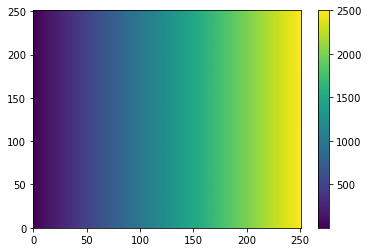

In [3]:
plt.pcolormesh(environment)
plt.colorbar()

# Initialize traits and environmental fields for speciation models

First we initialize one trait associated with elevation where the initial min/max provides the range of trait values that the individual will have and where the slope determines the linear relationship between environmental field and the optimal trait value for each individual on that field.|

In [4]:
trait_01_elev = FastscapeElevationTrait(topo_elevation=environment,
                                        init_trait_min=0.5,
                                        init_trait_max=0.5,
                                        lin_slope=0.95, 
                                        norm_min=environment.min(), 
                                        norm_max=environment.max(), 
                                        random_seed=1234)
trait_01_elev.initialize()

# dict of callables to generate initial values for each trait
init_trait_funcs =  {
    'trait_1': trait_01_elev.init_trait_func
}

# dict of callables to compute optimal values for each trait
opt_trait_funcs = {
    'trait_1': trait_01_elev.opt_trait_func
}

## Speciation model without trait-mediated competition

In [5]:
def model_woc_run(x=x, y=y, init_trait_funcs=init_trait_funcs, 
               opt_trait_funcs=opt_trait_funcs, 
               init_abundance=10, nb_radius=50, car_cap=30,
               sigma_env_trait=0.2, sigma_mov=5, sigma_mut=0.05,
               mut_prob=0.5, random_seed=1234, dt=1e0, num_gen=500,
              taxon_threshold=0.05):
    
    
    # define a speciation model using the specified parameter values
    model_woc = IR12SpeciationModel(grid_x=x, grid_y=y, init_trait_funcs=init_trait_funcs, 
                                 opt_trait_funcs=opt_trait_funcs, init_abundance=init_abundance, 
                                 nb_radius=nb_radius, car_cap=car_cap,
                                 sigma_env_trait=sigma_env_trait, 
                                 sigma_mov=sigma_mov, sigma_mut=sigma_mut,
                                 mut_prob=mut_prob, random_seed=random_seed,
                                 taxon_threshold=taxon_threshold)
    print(model_woc)
    # initialize the speciation model
    model_woc.initialize()
    # run the speciation model for the number of generations
    dfs = []
    for step in range(num_gen):
        model_woc.evaluate_fitness(dt)
        dfs.append(model_woc.to_dataframe())
        model_woc.update_individuals(dt)
    return pd.concat(dfs)

In [6]:
%time df1 = model_woc_run()
df1

<IR12SpeciationModel (individuals: not initialized)>
Parameters:
    lifespan: None
    random_seed: 1234
    always_direct_parent: True
    on_extinction: warn
    taxon_threshold: 0.05
    taxon_def: traits
    rho: 0
    nb_radius: 50
    car_cap: 30
    sigma_env_trait: 0.2
    sigma_mov: 5
    sigma_mut: 0.05
    mut_prob: 0.5



/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


CPU times: user 1min 56s, sys: 2.68 s, total: 1min 59s
Wall time: 7.61 s


,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,fitness,trait_0
0,0,0.0,0.0,244.174942,110.251531,1.0,0.0,2,0.077659,0.500000
1,0,0.0,0.0,95.048934,152.467702,1.0,0.0,9,0.850503,0.500000
2,0,0.0,0.0,230.811558,215.905324,1.0,0.0,4,0.131565,0.500000
3,0,0.0,0.0,65.423106,215.939418,1.0,0.0,4,0.522451,0.500000
4,0,0.0,0.0,79.774265,168.720328,1.0,0.0,5,0.694510,0.500000
...,...,...,...,...,...,...,...,...,...,...
278,499,499.0,0.0,164.122277,244.861108,6170.0,6140.0,1,0.989529,0.618993
279,499,499.0,0.0,171.857753,237.987136,6170.0,6140.0,1,0.990079,0.650285
280,499,499.0,0.0,171.368490,247.779506,6170.0,6140.0,1,0.999376,0.681879
281,499,499.0,0.0,168.692596,249.486006,6170.0,6140.0,1,0.898830,0.759658


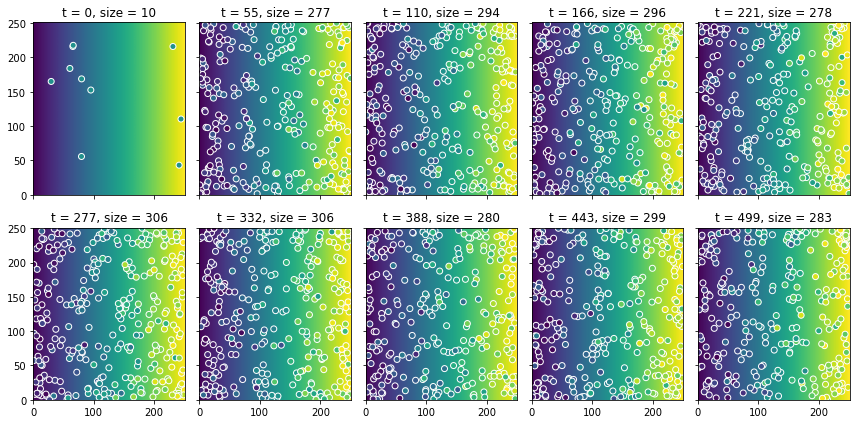

In [7]:
fig1, axes1 = plt.subplots(nrows=2, ncols=5, sharex='col', sharey='row',figsize=(12, 6))
for ax, print_step in zip(axes1.ravel(), np.linspace(0,df1.step.unique().size-1,10).astype(int)):
    pop = df1.groupby('step').get_group(print_step)
    ax.pcolormesh(environment)
    ax.scatter(pop.x, pop.y, c=pop.trait_0, edgecolor='w',vmin=0, vmax=1)
    ax.set_title(f't = {print_step}, size = {len(pop)}')
fig1.tight_layout()

Text(0.5, 0, 'Time (generations)')

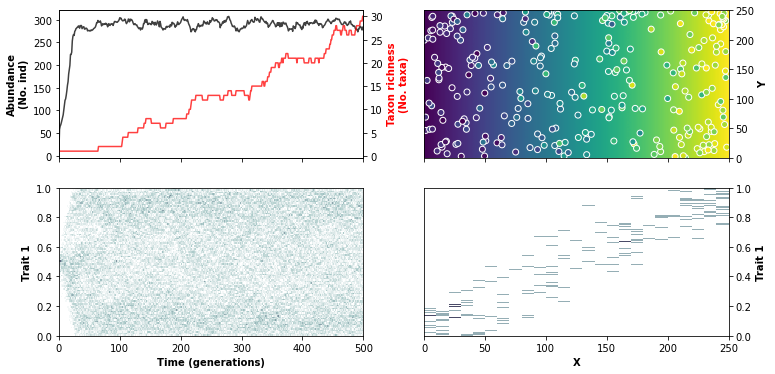

In [8]:
fig2, axs2 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
axs2[0,0].plot(df1.groupby('step').size(), c='black', alpha=0.75)
axs2_2 = axs2[0,0].twinx()
axs2_2.plot(df1.groupby(['step']).apply(lambda x: x.taxon_id.unique().size), c='red', alpha=0.75)

axs2[0, 1].pcolormesh(environment)
axs2[0, 1].scatter(df1['x'].loc[df1['step']==max(df1['step'])], 
                   df1['y'].loc[df1['step']==max(df1['step'])], 
                   c=df1['trait_0'].loc[df1['step']==max(df1['step'])],
                   edgecolor='w',vmin=0, vmax=1)
h,xedge,yedge,_=axs2[1,1].hist2d(x=df1['x'].loc[df1['step']==max(df1['step'])], 
                                 y=df1['trait_0'].loc[df1['step']==max(df1['step'])], 
                                 range=((0, x.max()), (0, 1)),
                                 bins=(25, 250), cmap='bone_r')
h,xedge,yedge,_=axs2[1,0].hist2d(x=df1['step'], y=df1['trait_0'], 
                                 range=((0, df1.step.unique().size), (0, 1)), 
                                 bins=(df1.step.unique().size, 100), cmap='bone_r')
axs2[0, 1].yaxis.set_label_position("right")
axs2[0, 1].yaxis.tick_right()
axs2[1, 1].yaxis.set_label_position("right")
axs2[1, 1].yaxis.tick_right()
axs2[0, 1].set_ylabel('Y', weight='bold')
axs2[0, 0].set_ylabel('Abundance\n(No. ind)', weight='bold')
axs2_2.set_ylabel('Taxon richness\n(No. taxa)', weight='bold', color='red')
axs2[1, 1].set_ylabel('Trait 1', weight='bold')
axs2[1, 0].set_ylabel('Trait 1', weight='bold')
axs2[1, 1].set_xlabel('X', weight='bold')
axs2[1, 0].set_xlabel('Time (generations)', weight='bold')

## Speciation model with trait-mediated competition

In [9]:
from adascape.base import DD03SpeciationModel

In [10]:
def model_wic_run(x=x, y=x, init_trait_funcs=init_trait_funcs, 
               opt_trait_funcs=opt_trait_funcs, init_abundance=10,
               car_cap_max=250, sigma_env_trait=0.2, 
               mut_prob=0.5, sigma_mut=0.05, sigma_mov=5, 
               sigma_comp_trait=0.9, sigma_comp_dist=0.1, 
               random_seed=1234, taxon_threshold=0.05,
               dt=1e0, num_gen=500):
    
    # define a speciation model using the specified parameter values
    model_wic = DD03SpeciationModel(grid_x=x, grid_y=y, init_trait_funcs=init_trait_funcs, 
                                 opt_trait_funcs=opt_trait_funcs, init_abundance=init_abundance,
                                 car_cap_max=car_cap_max, sigma_env_trait=sigma_env_trait, 
                                 mut_prob=mut_prob, sigma_mut=sigma_mut, sigma_mov=sigma_mov, 
                                 sigma_comp_trait=sigma_comp_trait, sigma_comp_dist=sigma_comp_dist, 
                                 random_seed=random_seed, taxon_threshold=taxon_threshold)
    
    print(model_wic)
    # initialize the speciation model
    model_wic.initialize()
    dfs = []
    # run the speciation model for the number of generations
    for step in range(num_gen):
        model_wic.evaluate_fitness(dt)
        dfs.append(model_wic.to_dataframe())
        model_wic.update_individuals(dt)
    return pd.concat(dfs)

In [11]:
%time df2 = model_wic_run()
df2

<DD03SpeciationModel (individuals: not initialized)>
Parameters:
    lifespan: None
    random_seed: 1234
    always_direct_parent: True
    on_extinction: warn
    taxon_threshold: 0.05
    taxon_def: traits
    rho: 0
    birth_rate: 1
    movement_rate: 5
    car_cap_max: 250
    sigma_env_trait: 0.2
    mut_prob: 0.5
    sigma_mut: 0.05
    sigma_mov: 5
    sigma_comp_trait: 0.9
    sigma_comp_dist: 0.1



/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


CPU times: user 5min 9s, sys: 16.2 s, total: 5min 26s
Wall time: 30 s


,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,events_i,death_i,trait_0
0,0,0.0,0.0,244.174942,110.251531,1.0,0.0,2,B,0.046692,0.500000
1,0,0.0,0.0,95.048934,152.467702,1.0,0.0,1,M,0.047645,0.500000
2,0,0.0,0.0,230.811558,215.905324,1.0,0.0,1,M,0.062604,0.500000
3,0,0.0,0.0,65.423106,215.939418,1.0,0.0,1,M,0.051044,0.500000
4,0,0.0,0.0,79.774265,168.720328,1.0,0.0,2,B,0.050755,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
211,499,499.0,1.0,176.938955,82.430624,13607.0,13559.0,1,M,0.997308,0.465807
212,499,499.0,1.0,232.952484,116.540837,13608.0,13560.0,2,B,0.954592,0.655126
213,499,499.0,1.0,190.979041,109.440327,13610.0,13562.0,0,D,1.143788,0.349230
214,499,499.0,1.0,47.057462,58.501922,13610.0,13562.0,1,M,1.005261,0.444355


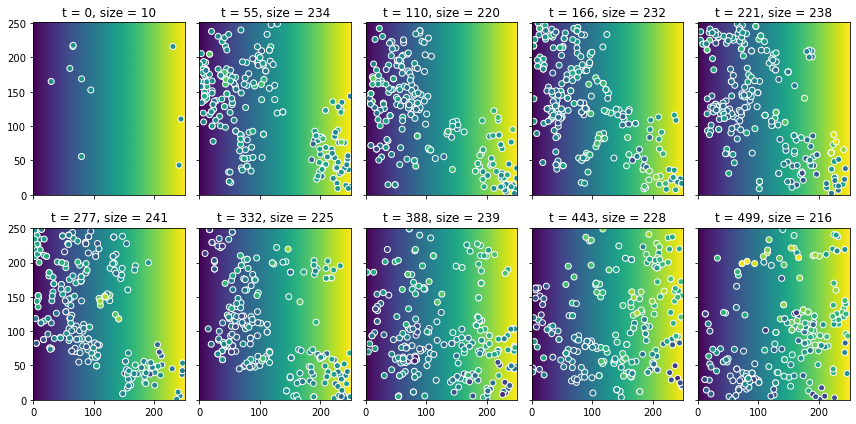

In [12]:
fig3, axes3 = plt.subplots(nrows=2, ncols=5, sharex='col', sharey='row',figsize=(12, 6))
for ax, print_step in zip(axes3.ravel(), np.linspace(0,df1.step.unique().size-1,10).astype(int)):
    pop = df2.groupby('step').get_group(print_step)
    ax.pcolormesh(environment)
    ax.scatter(pop.x, pop.y, c=pop.trait_0, edgecolor='w',vmin=0, vmax=1)
    ax.set_title(f't = {print_step}, size = {len(pop)}')
fig3.tight_layout()

Text(0.5, 0, 'Time (generations)')

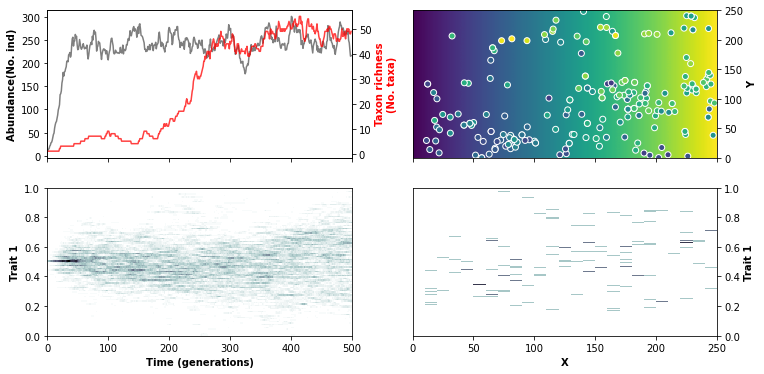

In [13]:
fig4, axs4 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
axs4[0,0].plot(df2.groupby('step').size(), c='black', alpha=0.5)
axs4_2 = axs4[0,0].twinx()
axs4_2.plot(df2.groupby(['step']).apply(lambda x: x.taxon_id.unique().size), c='red', alpha=0.75)

axs4[0, 1].pcolormesh(environment)
axs4[0, 1].scatter(df2['x'].loc[df2['step']==max(df2['step'])], 
                      df2['y'].loc[df2['step']==max(df2['step'])], 
                      c=df2['trait_0'].loc[df2['step']==max(df2['step'])], 
                      edgecolor='w',vmin=0, vmax=1)
h,xedge,yedge,_=axs4[1,1].hist2d(x=df2['x'].loc[df2['step']==max(df2['step'])], 
                                 y=df2['trait_0'].loc[df2['step']==max(df2['step'])], 
                                 range=((0, x.max()), (0, 1)),
                                 bins=(25, 250), cmap='bone_r')
h,xedge,yedge,_=axs4[1,0].hist2d(x=df2['step'], y=df2['trait_0'], 
                                 range=((0, df1.step.unique().size), (0, 1)), 
                                 bins=(df1.step.unique().size, 100), cmap='bone_r')
axs4[0, 1].yaxis.set_label_position("right")
axs4[0, 1].yaxis.tick_right()
axs4[1, 1].yaxis.set_label_position("right")
axs4[1, 1].yaxis.tick_right()
axs4[0, 1].set_ylabel('Y', weight='bold')
axs4[0, 0].set_ylabel('Abundance(No. ind)', weight='bold')
axs4_2.set_ylabel('Taxon richness\n(No. taxa)', weight='bold', color='red')
axs4[1, 1].set_ylabel('Trait 1', weight='bold')
axs4[1, 0].set_ylabel('Trait 1', weight='bold')
axs4[1, 1].set_xlabel('X', weight='bold')
axs4[1, 0].set_xlabel('Time (generations)', weight='bold')